In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

Using GPU 0: GeForce RTX 2080 Ti
Driver: 418.56


In [3]:
train_loader = VisionDataset(vision.FashionMNIST, 128, normalize=False)

In [4]:
g = builder([
    nn.Linear(110, 8*4*4),
    nn.BatchNorm1d(8*4*4),
    nn.LeakyReLU(),
    layer.Reshape((-1, 8, 4, 4)),
    AutoConvTransposeNet2d(8, 3, 'vgg', start_filter=128, min_filter=128, preact=False, pooling_type='interpolate', norm='batch'),
    nn.Conv2d(128, 1, 5),
    nn.Sigmoid(),
])  

8 128
128 128
128 128


In [5]:
d = builder([
    layer.ConditionProjection(
        builder([
            nn.Linear(10, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(),
            layer.Reshape((-1, 1, 28, 28)),
        ])
    ),
    AutoConvNet2d(2, 4, 'vgg', start_filter=128, max_filter=128, flatten=True, pooling_type='maxpool', preact=False, norm='batch'),
#     Auxiliary(builder([
#         nn.Linear(128, 10),
#         nn.LogSoftmax(-1)
#     ])),
    nn.Linear(128, 1),
#     nn.Sigmoid()
])

2 128
128 128
128 128
128 128


In [6]:
runner = Runner(GANModel(g, d, latent_vector_len=100, condition_vector_len=[10, 10], condition_onehot=True),
                train_loader, 
                None, 
                'rmsprop', 
                GANLoss('wgan'),
                monitor_state='g_loss',
                monitor_mode='min')

In [7]:
runner.init_model('orthogonal')
runner.test_init_model('orthogonal', verbose=True)

In [8]:
runner.fit(4)

  Epochs   train_d_loss  train_g_loss 
    1*       -2.0366        0.7366    


    2        -2.1363        0.9289    


    3        -1.7958        0.8715    


    4        -1.7841        0.8949    



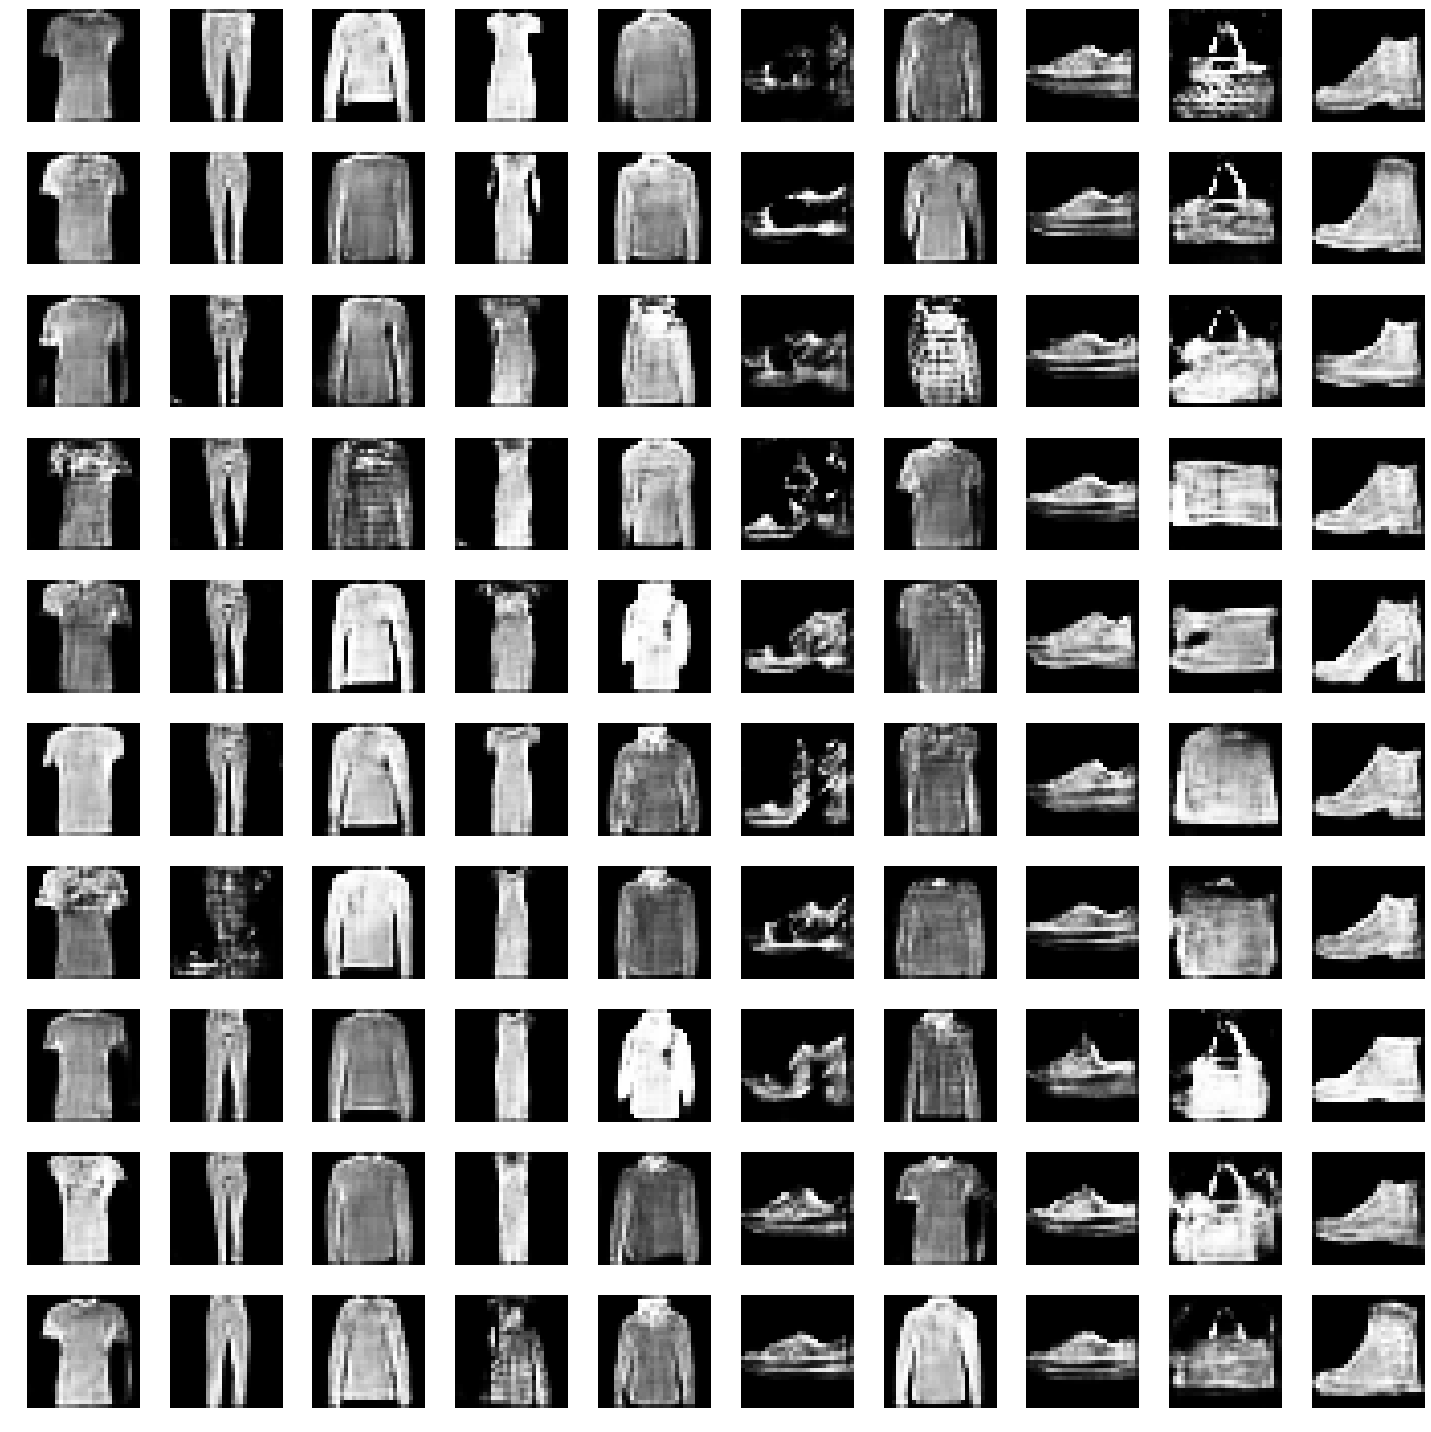

In [9]:
img = runner.model.sample(100, condition_data=list(range(10))*10)
import matplotlib.pyplot as plt
fig, arr = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    r = img[i][0].detach().cpu().numpy()#.transpose(1,2,0)
#     r -= r.min()
#     r /= r.max()
    arr[i//10][i%10].axis('off')
    arr[i//10][i%10].imshow(r, cmap='gray')
plt.tight_layout()
plt.show()

In [10]:
runner.report()

Experiment: default
Checkpoints are saved in ./checkpoint/default


Epoch,train_d_loss,train_g_loss,saved
1,-2.036605,0.736573,*
2,-2.136301,0.928866,
3,-1.795755,0.871496,
4,-1.784106,0.894885,
